In [1]:
import sys
print(sys.executable)

/media/HHD_2TB/baurai/aditya_vm/bin/python3.6


In [59]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedShuffleSplit
import cv2
import albumentations as A
import tensorflow as tf

print(f"Python version = {sys.version}")
print(f"Numpy version = {np.__version__}")
print(f"OpenCV version = {cv2.__version__}")
print(f"Tensorflow version = {tf.__version__}")

Python version = 3.6.9 (default, Oct  9 2020, 08:58:16) 
[GCC 6.3.0 20170516]
Numpy version = 1.19.5
OpenCV version = 4.5.1
Tensorflow version = 2.4.0


In [44]:
df = pd.DataFrame(pd.read_csv("filtered_metadata/metadata.csv"))

print("Shape = ", df.shape)
df.head()

Shape =  (66692, 5)


,image_id,label,patient_id,age,gender
0,00000002_000.png,0,2,80,M
1,00000004_000.png,1,4,82,M
2,00000005_000.png,0,5,69,F
3,00000005_001.png,0,5,69,F
4,00000005_002.png,0,5,69,F


In [45]:
IMAGE_SIZE = (256, 256)

In [46]:
transform = A.Compose([
    A.HorizontalFlip(p = 0.5)
])

In [47]:
def apply_albumin_augmentation(image, transform) : 
    augmented_image = transform(image = image)["image"]
    return augmented_image

# Stratified Sampling : 

Stratified sampling refers to a type of sampling method . With stratified sampling, we divides the population into separate groups, called strata. Then, a simple random sample is drawn from each group.

In [48]:
SIZE = 500

num_of_images = df.shape[0]
image_names = df["image_id"].values

print("Number of images = ", num_of_images)

Number of images =  66692


In [49]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)
for train_index, val_cum_test_index in split.split(df, df["label"]) : 
    stratified_train_set = df.loc[train_index]
    stratified_val_cum_test_set = df.loc[val_cum_test_index]

In [50]:
stratified_train_set.reset_index(drop = True, inplace = True)
print("Size of Stratified Training set = ", stratified_train_set.shape)
stratified_train_set.head()

Size of Stratified Training set =  (46684, 5)


,image_id,label,patient_id,age,gender
0,00012907_003.png,0,12907,40,M
1,00014264_002.png,0,14264,64,M
2,00001650_007.png,0,1650,62,M
3,00013894_000.png,1,13894,19,M
4,00017707_001.png,0,17707,25,M


In [51]:
stratified_val_cum_test_set.reset_index(drop = True, inplace = True)
print("Size of Stratified Validation cum Testing set = ", stratified_val_cum_test_set.shape)
stratified_val_cum_test_set.head()

Size of Stratified Validation cum Testing set =  (20008, 5)


,image_id,label,patient_id,age,gender
0,00002524_003.png,0,2524,62,M
1,00001023_002.png,0,1023,51,F
2,00015779_000.png,0,15779,34,F
3,00012051_005.png,0,12051,10,F
4,00020325_000.png,0,20325,53,F


We need to further split stratified_val_cum_test_set into **stratified_validation_set and stratified_test_set**.

In [52]:
split2 = StratifiedShuffleSplit(n_splits = 1, test_size = 0.5, random_state = 42)
for val_index, test_index in split2.split(stratified_val_cum_test_set, stratified_val_cum_test_set["label"]) : 
    stratified_val_set = stratified_val_cum_test_set.loc[val_index]
    stratified_test_set = stratified_val_cum_test_set.loc[test_index]

In [53]:
stratified_val_set.reset_index(drop = True, inplace = True)
print("Size of Stratified Validation set = ", stratified_val_set.shape)
stratified_val_set.head()

Size of Stratified Validation set =  (10004, 5)


,image_id,label,patient_id,age,gender
0,00005564_014.png,0,5564,43,F
1,00000488_002.png,0,488,35,F
2,00014792_002.png,1,14792,56,M
3,00014274_008.png,1,14274,34,F
4,00002874_000.png,0,2874,55,M


In [54]:
stratified_test_set.reset_index(drop = True, inplace = True)
print("Size of Stratified Test set = ", stratified_test_set.shape)
stratified_test_set.head()

Size of Stratified Test set =  (10004, 5)


,image_id,label,patient_id,age,gender
0,00008490_001.png,0,8490,58,M
1,00014877_020.png,0,14877,17,M
2,00025686_003.png,0,25686,52,M
3,00007060_016.png,0,7060,49,M
4,00012364_015.png,0,12364,51,F


# Analyze Label Distribution In Stratified Training/Val/Test Set

In [69]:
def analyze_label_distribution(dataframe, case = "train") : 
    """
    Training, validation and testing frames are passed to this method.
    """
    label_count = dict()
    for label in tqdm(dataframe["label"].values) : 
        if label not in label_count : 
            label_count[label] = 1
        else:
            label_count[label] += 1
    labels = ["Healthy Cases", "Nodular Cases"]
    counts = [label_count[0], label_count[1]]
    explode = (0.05, 0.05)
    
    plt.figure(figsize = (20, 12))
    plt.pie(counts, explode = explode, labels = labels, shadow = True, startangle = 90)
    plt.axis("equal")
    
    print("Healthy cases count = ", label_count[0])
    print("Nodular cases count = ", label_count[1])

  0%|          | 0/46684 [00:00<?, ?it/s]

Healthy cases count =  42252
Nodular cases count =  4432


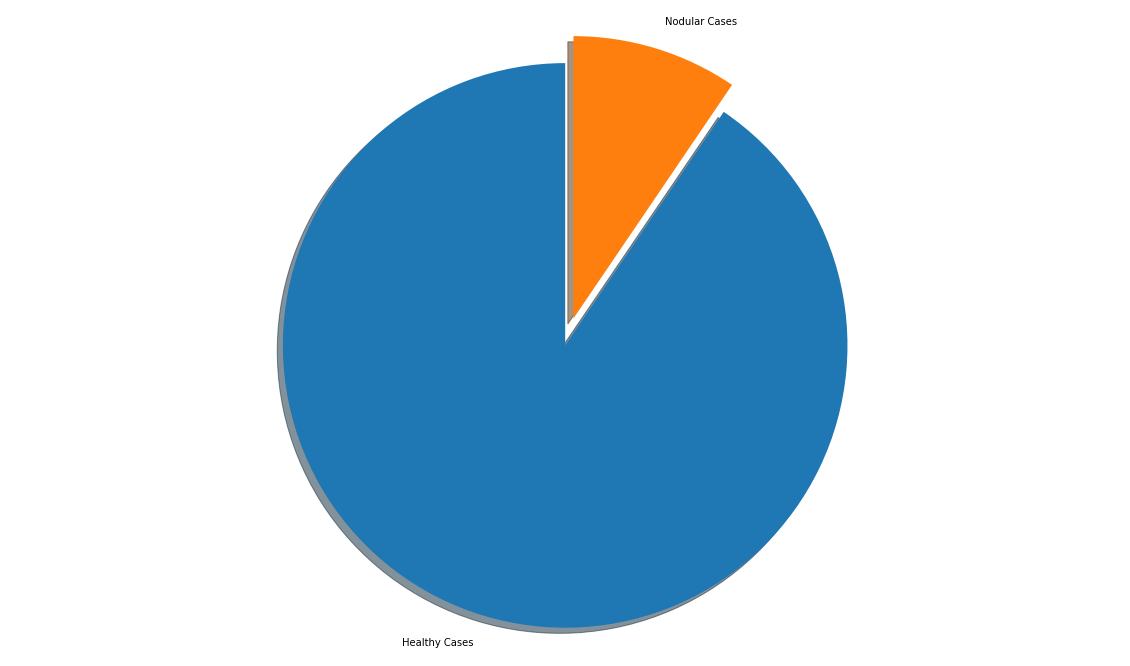

In [70]:
analyze_label_distribution(stratified_train_set)

  0%|          | 0/10004 [00:00<?, ?it/s]

Healthy cases count =  9054
Nodular cases count =  950


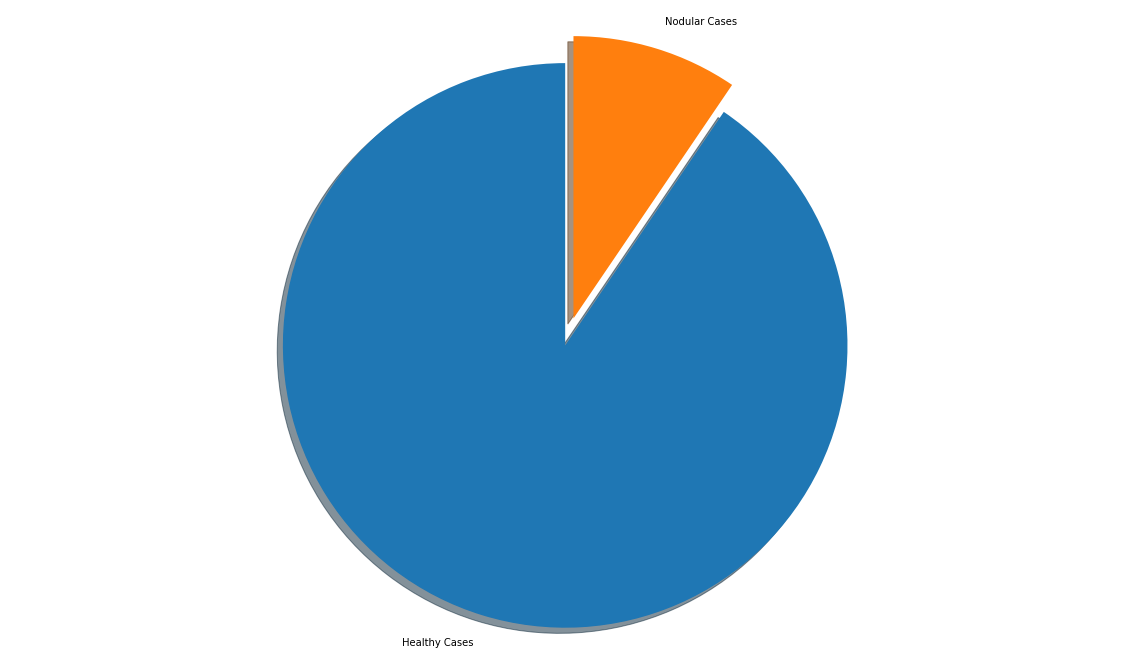

In [71]:
analyze_label_distribution(stratified_val_set)

  0%|          | 0/10004 [00:00<?, ?it/s]

Healthy cases count =  9055
Nodular cases count =  949


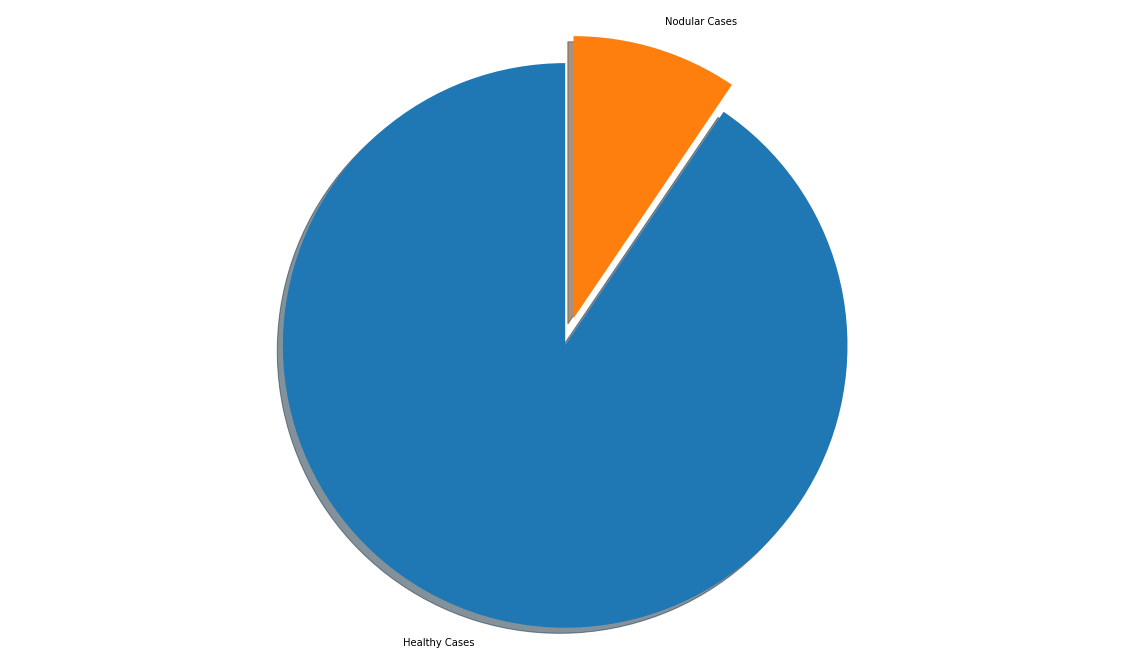

In [72]:
analyze_label_distribution(stratified_test_set)

Stratified sampling successful!